# iminuit tutorial

Welcome to the **iminuit tutorial**. You will learn basic usage of iminuit and how to approach standard fitting problems with iminuit. 

iminuit is a Python frontend to the *Minuit* library in C++, an integrated software that combines a local minimizer (called *Migrad*) and two error calculators (called *Hesse* and the *Minos*). You provide it an analytical function, which accepts one or several parameters, and an initial guess of the parameter values. It will then find a local minimum of this function starting from the initial guess. In that regard, iminuit minimizer is like other local minimizers, like those in scipy.optimize.

In addition, iminuit has the ability to compute **uncertainty estimates** for model parameters. iminuit was designed to solve statistics problems, where uncertainty estimates are an essential part of the result. The two ways of computing uncertainty estimates, *Hesse* and the *Minos*, have different advantages and disadvantages.

iminuit is the successor of pyminuit. If you used pyminuit before, you will find iminuit very familiar. An important feature of iminuit (and pyminuit) is that it uses introspection to detect the parameter names of your function. This is very convenient, especially when you work interactively in a Jupyter notebook. It also provides special output routines for Jupyter notebooks to pretty print the fit results, as you will see below.

In [1]:
# basic setup of the notebook
from matplotlib import pyplot as plt
import numpy as np

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

## Quick start

In this first section, we look at a simple case where line should be fitted to scattered $(x, y)$ data. A line has two parameters $(a, b)$. We go through the full fit, showing all basic steps to get you started quickly. In the following sections we will revisit the steps in more detail.

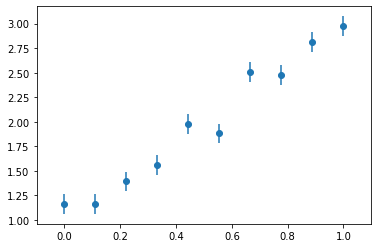

In [2]:
# our line model
def line(x, a, b):
    return a + x * b


# generate random toy data with random offsets in y
np.random.seed(1)
data_x = np.linspace(0, 1, 10)
data_yerr = 0.1  # could also be an array
data_y = line(data_x, 1, 2) + data_yerr * np.random.randn(len(data_x))

# draw toy data
plt.errorbar(data_x, data_y, data_yerr, fmt="o")
plt.xlim(-0.1, 1.1);

To recover the parameters $a$ and $b$ of the line model from this data, we need to a minimize a suitable cost function. The cost function must be twice differentiable and have a minimum at the optimal parameters. We use the method of least-squares here, whose cost function computes the sum of squared residuals between the model and the data. The task of iminuit is to find the minimum of that function. Let's do it:

a = 1.007 +/- 0.059
b = 1.966 +/- 0.099


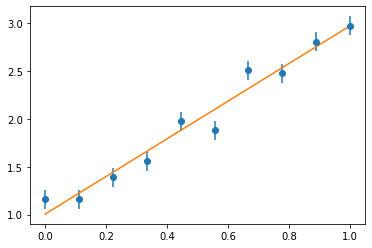

In [3]:
# iminuit contains a LeastSquares class to conveniently generate a least-squares cost function.
# We will revisit how to write this by hand in a later section.
least_squares = LeastSquares(data_x, data_y, data_yerr, line)

m = Minuit(least_squares, a=0, b=0)  # we need starting values for a and b

m.migrad()  # finds minimum of least_squares function
m.hesse()  # computes errors

# draw data and fitted line
plt.errorbar(data_x, data_y, data_yerr, fmt="o")
plt.plot(data_x, line(data_x, *m.values[:]))

# print parameter values and uncertainty estimates
for p in m.parameters:
    print("{} = {:.3f} +/- {:.3f}".format(p, m.values[p], m.errors[p]))

And that is already it for a basic fit. Easy, right?

In the following, we dive into the details step by step; how the Minuit object is initialized, how to run the algorithms, and how to get the results.

iminuit was designed to make it easy to fit functions like `least_squares(a, b)`, where the parameters are individual arguments of the function. There is an alternative function signature that Minuit supports, which is more convenient when you work a lot with numpy. Here, the parameters are passed as a numpy array. The two kinds of function definitions have each pros and cons. We will first dive how to work with functions of the first kind and come back to the second kind later. If you are interested only in the second kind, skip to the section **Alternative: Numpy functions**

## Initialize the Minuit object

To minimize a function, you create an instance of the Minuit class and pass the function to it. This does not start the minimization yet, this will come later. iminuit uses introspection to get the number and names of the function parameters automatically.

In [4]:
m = Minuit(
    least_squares
)  # we create an instance of Minuit and pass the function to minimize

<ipython-input-4-9ce608ed6951>:1: InitialParamWarning: Parameter a does not have neither initial value nor limits.
  m = Minuit(least_squares) # we create an instance of Minuit and pass the function to minimize
<ipython-input-4-9ce608ed6951>:1: InitialParamWarning: Parameter b does not have neither initial value nor limits.
  m = Minuit(least_squares) # we create an instance of Minuit and pass the function to minimize


Woah, warnings, we will resolve those in a moment. Note how iminuit refers to your parameters by correct names. The filename and line numbers shown in the warnings are bogus in Jupyter notebooks, but refer to the correct file and line when you use iminuit in a script or in the terminal shell.

### Initial parameter values

iminuit is a local minimizer. It searches for a local minimum by gradient-descent method from a starting point. If your function has several minima, the minimum found will depend on the starting point. Even if it has only one minimum, iminuit will converge to it faster if you start in the proximity of the minimum. If you don't provide a starting value for a parameter, it uses 0. You almost always want to specify a starting point.

You can set the starting point using the parameter names as keywords, `<name> = <value>`.

In [5]:
m = Minuit(least_squares, a=5, b=5)  # pass starting values for a and b

No more warnings, we are good to go.

### Silence warnings

If you want to quickly minimize a function and you know that the defaults are ok, you can explicitly silence all warnings, like so:

In [6]:
m = Minuit(least_squares, pedantic=False)  # silence warnings, use default values

The default value for unbounded parameters is 0. For a bounded parameter, it is the middle of the bounded range.

### Inspecting current parameters

You can check the current parameter values and settings with the method `Minuit.params` at any time. It returns a special list of `Param` objects which pretty-prints in Jupyter and in the terminal.

In [7]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,0.0,0.1,,,,,
1,b,0.0,0.1,,,,,



This produces a nice table with numbers rounded according to the rules of the *Particle Data Group*. The table will be updated once you run the actual minimization. To look at the initital conditions later, use `Minuit.init_params`. We will come back to the meaning of *Hesse Error* and *Minos Error* later.

In [8]:
print(m.params)  # the terminal output is also pretty thanks to unicode characters

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    0.0    │    0.1    │            │            │         │         │       │
│ 1 │ b    │    0.0    │    0.1    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


In [9]:
# to see the underlying Python objects, use repr()
print(repr(m.params))

[Param(number=0, name='a', value=0.0, error=0.1, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='b', value=0.0, error=0.1, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)]


### Parameters with limits

iminuit allows you to set parameter limits. Often a parameter is limited mathematically or physically to a certain range. For example, if your function contains `sqrt(x)`, then $x$ must be non-negative, $x \ge 0$. You can set upper-, lower-, or two-sided limits for each parameter individually with keywords `limit_<name>`:

- lower limit: use `limit_<name> = (<value>, None)` or `(<value>, float("infinity"))`
- upper limit: use `limit_<name> = (None, <value>)` or `(-float("infinity"), <value>)`
- two-sided limit: use `limit_<name> = (<min_value>, <max_value>)`

To impose the limits $a \ge 0$ and $0 \le b \le 10$ in our example, we use:

In [10]:
m = Minuit(
    least_squares,
    a=5,
    b=5,
    error_a=0.1,
    error_b=0.1,
    limit_a=(0, None),
    limit_b=(0, 10),
    errordef=1,
)
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,5.0,0.1,,,0,,
1,b,5.0,0.1,,,0,10,


### Fixing and releasing parameters

Sometimes you have a parameter which you want to set to a fixed value temporarily. Perhaps you have a guess for its value, and you want to see how the other parameters adapt when this parameter is fixed to that value.

Or you have a complex function with many parameters that do not all affect the function at the same scale. Then you can manually help the minimizer to find the minimum faster by first fixing the less important parameters to initial guesses and fit only the important parameters. Once the minimum is found under these conditions, you can release the fixed parameters and optimize all parameters together. Minuit remembers the last state of the minimization and starts from there. The minimization time roughly scales with the square of the number of parameters. Iterated minimization over subspaces of the parameters can reduce that time.

To fix an individual parameter, you use the keyword `fix_<name> = True`. In our example, we fix $x$, like so:

In [11]:
m = Minuit(least_squares, a=5, b=5, fix_a=True)
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,5.00,0.05,,,,,yes
1,b,5.00,0.05,,,,,


In [12]:
# migrad will not vary a, only b
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4629                       │         Nfcn = 11 (11 total)         │
│ EDM = 1.1e-16 (Goal: 0.0002)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   5.00    │   0.05    │            │            │         │         │  yes  │
│ 1 │ b    │   -3.71   │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [13]:
# now we release a and fix b and minimize again
m.fixed["a"] = False
m.fixed["b"] = True
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 3293                       │         Nfcn = 13 (24 total)         │
│ EDM = 5.85e-17 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   3.844   │   0.032   │            │            │         │         │       │
│ 1 │ b    │   -3.71   │   0.05    │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [14]:
# we could iterate this and would slowly approach the minimum,
# but that's silly; instead we release both parameters and run again
m.fixed[:] = False
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.06                      │         Nfcn = 27 (51 total)         │
│ EDM = 3.31e-15 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.01    │   0.06    │            │            │         │         │       │
│ 1 │ b    │   1.97    │   0.10    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

### Varying starting points for minimization

It is sometimes useful to change the values of some fixed parameters by hand and fit the others or to restart the fit from another starting point. Let's try that.

In [15]:
m.fixed["a"] = True
m.values["a"] = 0.5
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 88.55                      │         Nfcn = 8 (59 total)          │
│ EDM = 3e-16 (Goal: 0.0002)       │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.50    │   0.06    │            │            │         │         │  yes  │
│ 1 │ b    │   2.69    │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [16]:
m.values["a"] = 1
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.08                      │         Nfcn = 8 (67 total)          │
│ EDM = 2.19e-25 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.00    │   0.06    │            │            │         │         │  yes  │
│ 1 │ b    │   1.98    │   0.05    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

If the cost function has several minima, changing the starting value can be used to find the other minimum.

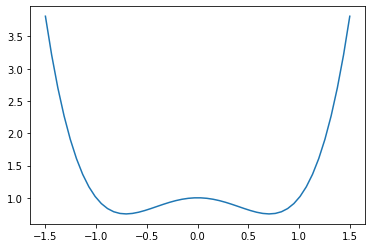

In [17]:
def cost_function_with_two_minima(x):
    return x ** 4 - x ** 2 + 1


x = np.linspace(-1.5, 1.5)
plt.plot(x, cost_function_with_two_minima(x));

In [18]:
# starting at -0.1 (0.1) will give the left (right) minimum
m = Minuit(cost_function_with_two_minima, x=-0.1, errordef=1)
m.migrad()
print("starting value -0.1, minimum at", m.values["x"])

m.values["x"] = 0.1
m.migrad()
print("starting value +0.1, minimum at", m.values["x"])

starting value -0.1, minimum at -0.7085906080341975
starting value +0.1, minimum at 0.708796091342642


### Advanced: Error definition

If you do not use one of the cost functions from the `iminuit.cost` module, you need to pass an additional parameter to Minuit. Let's go back to the custom least-squares function `least_squares` for a moment and try to initialize with that.

In [19]:
# a simple least-squares cost function looks like this...
def custom_least_squares(a, b):
    ym = line(data_x, a, b)
    z = (data_y - ym) / data_yerr ** 2
    return np.sum(z ** 2)


m = Minuit(custom_least_squares, a=5, b=5)  # pass starting values for a and b

<ipython-input-19-6f87a77da51f>:7: InitialParamWarning: errordef is not given, defaults to 1.
  m = Minuit(custom_least_squares, a=5, b=5) # pass starting values for a and b


Minuit now warns about its default value for the `errordef` keyword, which may not be appropriate. Setting this is not needed for the cost functions in `iminuit.cost`, but for custom cost functions.

The `errordef` keyword is needed to get correct uncertainties from Minuit. In statistical problems, there are two kinds of cost functions to minimize, the *negative log-likelihood* and the *least-squares* function. Each has a corresponding value for `errordef`:
 - `0.5` or the constant `Minuit.LIKELIHOOD` for negative log-likelihood functions 
 - `1` or the constant `Minuit.LEAST_SQUARES` for least-squares functions 

The origin of these numbers is not too complicated, but cannot be explained briefly. If you are curious, have a look into the tutorial "Error computation with HESSE and MINOS", which explains in depth how uncertainties are computed and where this value comes from.

If you don't care about uncertainty estimates (but why are you using Minuit then?), just use the default `errordef=1`.

For our custom cost function, we need to pass `errordef=1` or `errordef=Minuit.LEAST_SQUARES`, because it is of the least-squares type. If we do that, the warning disappears.

In [20]:
m = Minuit(custom_least_squares, a=5, b=5, errordef=Minuit.LEAST_SQUARES)

Hint: If you add an attribute called `errordef` to your cost function, Minuit will use that. That's how the builtin cost functions allow to skip setting it.

### Advanced: Initial step sizes

Minuit uses a gradient-descent method to find the minimum and the gradient is computed numerically using finite differences. The initial step size is used to compute the first gradient. A good step size is small compared to the curvature of the function, but large compared to numerical resolution. Using a good step size can slightly accelerate the convergence, but Minuit is not very sensitive to the choice. If you don't provide a value, iminuit will guess a step size based on a heuristic.

You can set initital step sizes with keywords, `error_<name> = <step size>`. Using an appropriate step size is important when you have you a parameter which has physical bounds. Varying the initial parameter value by the step size may not create a situation where the parameter goes outside of its bounds. For example, a parameter $x$ with $x > 0$ and initital value $0.1$ may not have a step size of $0.2$.

In our example, we could use an initital step size of $\Delta a = \Delta b = 0.1$.

In [21]:
m = Minuit(least_squares, a=5, b=5, error_a=0.1, error_b=0.1)

### Advanced: Override paramater name detection

iminuit tries hard to detect the parameter names and is pretty good at it. For example, if you pass a functor instead of a function, it will use the arguments of the `__call__` method, automatically skipping `self`.

You can check which parameter names iminuit finds for your function with the `describe` function.

In [22]:
from iminuit import describe


def foo(x, y, z):
    pass


assert describe(foo) == ["x", "y", "z"]


class Foo:
    def __call__(self, a, b):
        pass


assert describe(Foo()) == ["a", "b"]

This works very well, but the parameter names cannot always be determined. For example, in case of functions which accept a variable number of arguments.

In [23]:
def bar(*args):  # function with variable number of arguments
    return np.sum((np.array(args) - 1) ** 2)


try:
    describe(bar)  # this will raise a TypeError
except TypeError as e:
    import traceback as tb

    tb.print_exc()

Traceback (most recent call last):
  File "<ipython-input-23-467b3a978ace>", line 5, in <module>
    describe(bar)  # this will raise a TypeError
  File "/usr/local/lib/python3.8/site-packages/iminuit/util.py", line 442, in describe
    raise TypeError("Unable to obtain function signature")
TypeError: Unable to obtain function signature


A `TypeError` is raised, because `describe` cannot detect the number and names of the parameters in this case. If you work with functions that accept a variable number of arguments a lot, it is better to use a cost function which accepts a parameter array (this is explained in the next section).

When iminuit cannot detect the arguments, but you know how many arguments there are, or if you simply want to override the names found by iminuit, you can do that with the keyword `name`, like so:

In [24]:
m = Minuit(bar, name=("a", "b"), a=1, b=2, errordef=1)
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.867e-19                  │         Nfcn = 24 (24 total)         │
│ EDM = 2.87e-19 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │     1     │     1     │            │            │         │         │       │
│ 1 │ b    │     1     │     1     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

### Alternative initialization with vectorized functions

You can also use iminuit with functions that accept numpy arrays. This has pros and cons.

**Pros**
- Easy to change number of fitted parameters
- Sometimes simpler function body that's easier to read
- Slightly more efficient, although this is probably not noticable unless you have >100 parameters

**Cons**
- iminuit cannot figure out names for each parameter

To demonstrate, use a version of the line model which accepts the parameters as a numpy array.

In [25]:
def line_np(x, par):
    return np.polyval(par, x)  # for par = (a, b) this is a line

Calling `line_np` with more or less arguments is easy and will use a polynomial of the corresponding order to predict the behavior of the data. This is handy. 

Such a model works with the builtin cost functions, but we need to use the method `Minuit.from_array_func` to pass it:

In [26]:
least_squares_np = LeastSquares(data_x, data_y, data_yerr, line_np)

m = Minuit.from_array_func(least_squares_np, (5, 5))
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.00,0.05,,,,,
1,x1,5.00,0.05,,,,,


The first argument after the function in `Minuit.from_array_func` is the array of starting values. Any sequence will do here. iminuit uses its length to detect how many parameters the model has.

One can use the keywords `limit`, `fix`, and `error` to set parameter limits, fix parameters, or set initial step sizes. These must be sequences with the same length as the starting point. For `error` and `limit`, it is also allowed to give a single step size or a single limit, which is then used for all parameters.

By default, the parameters are named automatically `x0` to `xN`. One can override this with the keyword `name`, passing a sequence of parameter names.

In [27]:
m = Minuit.from_array_func(
    least_squares_np,
    (5, 5),
    fix=(True, False),
    limit=((0, None), (0, 10)),
    name=("a", "b"),
)
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,5.00,0.05,,,0,,yes
1,b,5.00,0.05,,,0,10,


Since `least_squares_np` works for parameter arrays of any length, one can easily change the number of fitted parameters.

In [28]:
# fit a forth order polynomial
m = Minuit.from_array_func(least_squares_np, (5, 5, 5, 5))
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.00,0.05,,,,,
1,x1,5.00,0.05,,,,,
2,x2,5.00,0.05,,,,,
3,x3,5.00,0.05,,,,,


It is often useful to try different orders of a polynomial model. If the order is too small, the polynomial will not follow the data. If it is too large, it will overfit the data and pick up random fluctuations and not the underlying trend. One can figure out the right order by experimenting or using an algorithm like cross-validation.

### Alternative interface: iminuit.minimize

Those familiar with scipy may find the `minimize` function useful. It exactly mimics the function interface of `scipy.optimize.minimize`, but uses `Minuit` for the actual minimization. The `scipy` package must be installed to use it.

In [29]:
from iminuit import minimize  # has same interface as scipy.optimize.minimize

minimize(least_squares_np, (5, 5))

      fun: 14.064905067721478
 hess_inv: array([[ 0.00490909, -0.00245455],
       [-0.00245455,  0.00172727]])
  message: 'Optimization terminated successfully.'
   minuit: <iminuit._minuit.Minuit object at 0x123fc5ac0>
     nfev: 32
     njev: 0
  success: True
        x: array([1.96603643, 1.00726769])

This interface is handy if you want to be able to switch between iminuit and `scipy.optimize.minimize` but we recommend the standard interface instead. It is an advantage of Minuit that you can interact and manually steer the minimization process. This is not possible with a functional interface like `minimize`.

## Minimizing the cost function

Calling `Minuit.migrad()` runs the actual minimization with the Migrad algorithm. Migrad essentially tries a Newton-step and if that does not produce a smaller function value, it tries a line search along the direction of the gradient. So far so ordinary. The clever bits in Migrad are how various pathological cases are handled.

Let's look at the output of `Minuit.migrad()`.

In [30]:
m = Minuit(least_squares, a=5, b=5)
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 14.06                      │         Nfcn = 30 (30 total)         │
│ EDM = 1.37e-22 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1.01    │   0.06    │            │            │         │         │       │
│ 1 │ b    │   1.97    │   0.10    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

The method returns two dict-like objects, which contain information about the function minimum and the parameter state. In a notebook, these objects are pretty-printed as tables. This is good for a quick check:

- All blocks should be green.
- Purple means something bad. 
- Yellow may be bad or not. Be careful.

Let's look at the actual object. The first is the function minimum `fmin`:

In [31]:
print(repr(m.fmin))  # use repr() to avoid pretty printing

FMin(fval=14.064905067721462, edm=1.3727353506293662e-22, tolerance=0.1, nfcn=30, nfcn_total=30, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False, has_parameters_at_limit=False, ngrad=0, ngrad_total=0)


The most important one here is `is_valid`. If this is false, the fit did not converge and the result is useless. If that happens, there can be many reasons.

- The fit function is not analytical everywhere in the parameter space or does not have a local minimum (the minimum may be at infinity, the extremum may be a saddle point or maximum). Indicators for this are `is_above_max_edm=True`, `hesse_failed=True`, `has_posdef_covar=False`, or `has_made_posdef_covar=True`.
- Migrad reached the call limit before the convergence so that `has_reached_call_limit=True`. The used number of function calls is `nfcn`, and the call limit can be changed with the keyword argument `ncall` in the method  `Minuit.migrad`. Note that `nfcn` can be slightly larger than `ncall`, because Migrad internally only checks this condition after a full iteration step, in which several function calls can happen.

Migrad detects convergence by a small `edm` value, the *estimated distance to minimum*. This is the difference between the current minimum value of the minimized function and the next prediction based on a local quadratic approximation of the function (something that Migrad computes as part of its algorithm). If the fit did not converge, `is_above_max_edm` is true.

If you are interested in parameter uncertainties, you should make sure that:

- `has_covariance`, `has_accurate_covar`, and `has_posdef_covar` are true.
- `has_made_posdef_covar` and `hesse_failed` are false.

The second object of interest after the fit is the parameter list, which we already know.

In [32]:
print(repr(m.params))  # use repr() to avoid pretty printing

[Param(number=0, name='a', value=1.007267694540704, error=0.0587753822609482, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='b', value=1.9660364327566, error=0.09908674038017995, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)]


This is a list of dict-like `Param` objects which contain information about the fitted parameters. Important fields are:
- `number`: parameter index.
- `name`: parameter name.
- `value`: value of the parameter at the minimum.
- `error`: uncertainty estimate for the parameter value.

Whether the uncertainty estimate is accurate depends on the correct mathematical modeling of your fitting problem and using the right `errordef` value for Minuit. What do we mean by correct mathematical modelling? If you look into the function `simple_least_squares(a, b)`, you see that each squared residuals is divided by the expected variance of the residual. This is necessary to get accurate uncertainty estimates for the parameters.

Sometimes the expected variance of the residual is not well known. If the function to minimize is a least-squares function, there is a simple test to check whether the residual variances are ok. One should look at the function value at the minimum, here given by `fmin.fval`, and divide it by the difference of the number of residuals and the number of fitted parameters, which can be conveniently queried with the attribute `nfit`. This is so-called reduced chi2.

In [33]:
m.fval / (len(data_y) - m.nfit)  # reduced chi2

1.7581131334651827

This value should be around 1. The more data points one has, the closer. If the value is much larger than 1, then the data variance is underestimated or the model does not describe the data. If the value is much smaller than 1, then the data variance is overestimated (perhaps because of positive correlations between the fluctuations of the data values).

##  Parameter uncertainties, covariances, and confidence intervals

You saw how to get the uncertainty of each individual parameter, but parameters are usually correlated. This is essential additional information if you want to work with parameter uncertainties seriously. We will discuss next how you access that.

Minuit offers two ways to compute the parameter uncertainties, Hesse and Minos. Both have pros and cons.

### Hesse for covariance and correlation matrices

The Hesse algorithm numerically computes the matrix of second derivatives at the function minimum (called the Hesse matrix) and inverts it. The Hesse matrix is symmetric by construction. In the limit of infinite data samples to fit, the result of this computation converges to the true covariance matrix of the parameters. It often is already a good approximation even for finite statistic. These errors obtained from this method are sometimes called *parabolic errors*, because the Hesse matrix method is exact if the function is a hyperparabola (third and higher-order derivatives are all zero).

Pros:
- (Comparably) fast computation.
- Provides covariance matrix for error propagation.

Cons:
- May not have good coverage probability when sample size is small

The Migrad algorithm computes an approximation of the Hesse matrix automatically during minimization. When the default strategy is used, Minuit does a check whether this approximation is sufficiently accurate and if not, it computes the Hesse matrix automatically.

All this happens inside C++ Minuit and is a bit intransparent, so to be on the safe side, we recommend to call `Minuit.hesse` explicitly after the minimization, if exact errors are important.

In [34]:
# let's mess up the current errors a bit so that hesse has something to do
m.errors[:] = (0.16, 0.2)
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,1.01,0.16,,,,,
1,b,1.97,0.20,,,,,


In [35]:
m.hesse()

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,1.01,0.06,,,,,
1,b,1.97,0.10,,,,,


The call returns the updated parameter list, which is again rendered as a table.

#### Correlation and Covariance Matrix

To see the correlation matrix of the parameters, you do:

In [36]:
m.matrix(correlation=True)

,a,b
a,1.00,-0.84
b,-0.84,1.00


The paramaters $a$ and $b$ are stronly anti-correlated, which is highlighed by the blue color of the off-diagonal elements.

Correlation is not necessarily a bad thing, but if you have freedom in redefining the parameters of the fit function, it is good to chose parameters which are not strongly correlated.

Minuit cannot accurately minimise the function if two parameters are (almost) perfectly (anti-)correlated. It also means that one of two parameters is superfluous, it doesn't add new information. You should rethink the fit function in this case and try to remove one of the parameters from the fit.

You can also look at the covariance matrix:

In [37]:
m.matrix()

,a,b
a,0.003,-0.005
b,-0.005,0.010


To see the matrices as Python objects, use `repr`:

In [38]:
print(repr(m.matrix(correlation=True)))  # correlation matrix
print(repr(m.matrix()))  # covariance matrix

((1.0, -0.8429272304870631), (-0.8429272304870631, 1.0))
((0.003454545455724434, -0.004909090910416343), (-0.004909090910416343, 0.00981818181865261))


If you want the matrix as a numpy array (useful for error propagation), use the `np_` methods:

In [39]:
print(m.np_matrix())  # m.np_covariance() also works

[[ 0.00345455 -0.00490909]
 [-0.00490909  0.00981818]]


### Minos for non-parabolic minima

Minuit has another algorithm to compute uncertainties: Minos. It implements the so-called profile likelihood method, where the neighborhood around the function minimum is scanned until the contour is found where the function increase by the value of `errordef`. The contour defines a confidence region that covers the true parameter point with a certain probability. The probability is exactly known in the limit of infinitely large data samples, but approximate for the finite case. Please consult a textbook about statistics about the mathematical details or look at the tutorial "Error computation with HESSE and MINOS".

Pros:
- Produces pretty confidence regions in 2D (or higher) for scientific plots

Cons:
- Computationally expensive
- Asymmetric errors are difficult to error-propagate

Minos is not automatically called during minimization, it needs to be called explicitly afterwards, like so:

In [40]:
m.minos()

┌──────────┬───────────────────────┬───────────────────────┐
│          │           a           │           b           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.06   │   0.06    │   -0.1    │    0.1    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘

By now you are probably used to see green colors, which indicate that Minos ran successful. Be careful when these are red instead, Minos can fail. The fields in the table mean the following:
- Valid: Whether Minos considers the scan result valid.
- At Limit: True if Minos hit a parameter limit before the finishing the contour, which would be bad.
- Max FCN: True if Minos reached the maximum number of allowed calls before finishing the contour, also bad.
- New Min: True if Minos discovered a deeper local minimum in the neighborhood of the current one. Not necessarily bad, but should not happen.

The errors computed by Minos are now also shown in the parameter list:

In [41]:
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,1.01,0.06,-0.06,0.06,,,
1,b,1.97,0.10,-0.10,0.10,,,


If the absolute values of the Minos errors are very close to the Hesse Error, the function is well approximated by a hyperparabola around the minimum. You can use this as a check instead of explicitly plotting the function around the minimum (for which we provide tools, see below).

### Coverage probability of intervals constructed with Hesse and Minos algorithms

In applications, it is important to construct confidence regions with a well-known coverage probability. As previously mentioned, the coverage probability of the intervals constructed from the uncertainties reported by Hesse and Minos are not necessarily the standard 68 %.

Whether Hesse or Minos produce an interval with a coverage probability closer to the desired 68 % in finite samples depends on the case. There are theoretical results which suggest that Hesse should be better, but we also found special cases where Minos intervals performed better.

Many sources claim that Minos works better when the cost function is not parabolic around the minimum; that is not true. We discovered in toy experiments and through literature research that it is not that simple. So as a rule-of-thumb, use Hesse as the default and try both algorithms if accurate coverage probability matters.

## Quick access to fit results

If working with the dicts returned by `Minuit.migrad` and `Minuit.minos` is not your thing, you can also get the fit results with properties and methods. There are many, please check the reference of `Minuit`. Here are the most important ones:

In [42]:
print(m.values)  # dict-like view of the parameter values
# access values by name or index
print("by name", m.values["a"])
print("by index", m.values[0])

# you can iterate over the view like you would over a dict
for key, value in m.values.items():
    print((key, value))

# slicing also works as if m.values was an array
print(m.values[:1])

print("Hesse errors")
print(m.errors)  # dict-like view of symmetric uncertainties
# m.errors supports the same access as m.values

print("Minos errors")
print(
    repr(m.merrors)
)  # asymmetric uncertainties, we use repr() here to avoid the normal pretty print
print("Hesse covariance")
print(m.covariance)  # the covariance matrix computed by Hesse

<ValueView of Minuit at 123764e20>
  a: 1.007267694540704
  b: 1.9660364327566
by name 1.007267694540704
by index 1.007267694540704
('a', 1.007267694540704)
('b', 1.9660364327566)
[1.007267694540704]
Hesse errors
<ErrorView of Minuit at 123764e20>
  a: 0.0587753813745554
  b: 0.09908673886374811
Minos errors
MErrors([('a', MError(name='a', is_valid=True, lower=-0.05877538136430983, upper=0.05877538136474233, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=12, min=1.007267694540704)), ('b', MError(name='b', is_valid=True, lower=-0.09908673886103192, upper=0.0990867388617138, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=12, min=1.9660364327566))])
Hesse covariance
{('a', 'a'): 0.003454545455724434, ('a', 'b'): -0.004909090910416343, ('

Note that you can play around with iminuit by assigning new values to `m.values` and `m.errors`. The values will be used as a starting point when you call `m.migrad()` again.

There are also corresponding methods that return numpy arrays, convenient if you use numpy functions. Note that these methods create copies. The numpy arrays are not views like the attributes. Changing the values of the numpy array does not change the state that `Minuit` sees.

In [43]:
# note these are methods and not a properties
print(m.np_values())
print(m.np_errors())
print(m.np_merrors())
print(m.np_covariance())

[1.00726769 1.96603643]
[0.05877538 0.09908674]
[[0.05877538 0.09908674]
 [0.05877538 0.09908674]]
[[ 0.00345455 -0.00490909]
 [-0.00490909  0.00981818]]


The layout for most of these is straight-forward, but for `Minuit.np_merrors()` it is different. The layout returned by `Minuit.np_merrors()` follows the convention `[abs(delta_down), delta_up]` that is used by `matplotlib.pyplot.errorbar`. This makes passing Hesse and Minos errors to matplotlib straight-forward. You can see an example here:

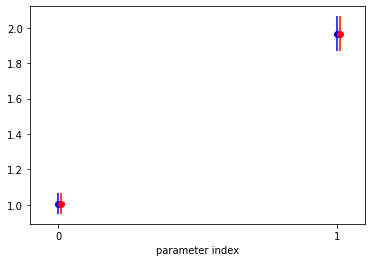

In [44]:
v = m.np_values()
ve = m.np_errors()
vm = m.np_merrors()
# show hesse errors
plt.errorbar((0, 1), v, ve, fmt="ob")
# show minos errors
plt.errorbar((0.01, 1.01), v, vm, fmt="or")
# add a little offset so that the error bars don't overlap
plt.xlabel("parameter index")
plt.xticks((0, 1))
plt.xlim(-0.1, 1.1);

## Plotting

iminuit comes with buildin methods to draw the confidence regions around the minimum, like so:

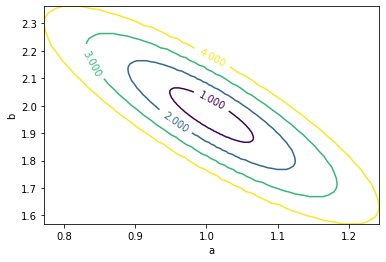

In [45]:
m.draw_mncontour("a", "b", nsigma=4)
# nsigma=4 says: draw four contours from sigma=1 to 4

In [46]:
# get individual minos contours for plotting them yourself
param_a, param_b, ctr_xy = m.mncontour("a", "b", sigma=2, numpoints=10)
print(ctr_xy)

[(0.8897169318117961, 2.1330822534773777), (0.9163008437866519, 2.0277737638507602), (0.9632011768652332, 1.9298097851624467), (1.0228126892197689, 1.8382597795801836), (1.1063544334027382, 1.7678629550340816), (1.1248184572698996, 1.7989906113647052), (1.0982345454511078, 1.9042991012687556), (1.0513342123106382, 2.0022630801833223), (0.9917226998310339, 2.093813085974047), (0.9081809552961845, 2.164209910479572)]


If you need to inspect the cost function around the minimum because MINUIT warns you about some issues, you can quickly scan it with a call to `Minuit.draw_profile`.

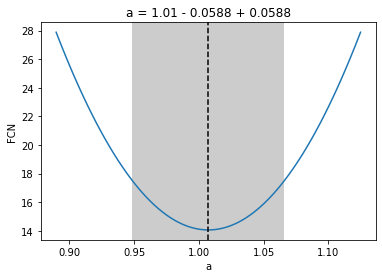

In [47]:
m.draw_profile("a");

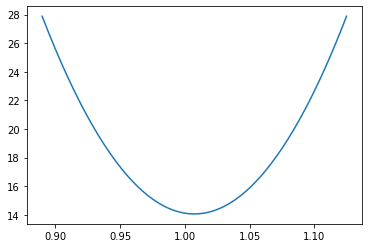

In [48]:
# or use this to plot the result of the scan yourself
a, fa = m.profile("a")
plt.plot(a, fa);

Alternativel, you can use `mnprofile` to do a full profile likelihood scan. This mimics what MINOS does to compute confidence intervals. If you have trouble with MINOS, running this may help to inspect the issue.

This is computationally expensive, since the scan runs MIGRAD for each point on the profile.

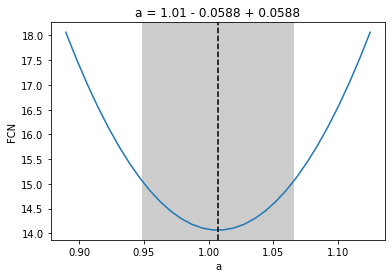

In [49]:
m.draw_mnprofile("a");

Finally, you can also look at the 2D contours of the cost function around the minimum. Note that these are just contours of the fit function, not confidence regions. The latter you can only get from `mncontour`.

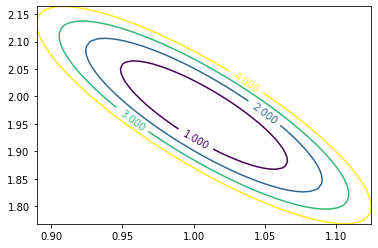

In [50]:
x, y, z = m.contour("a", "b", subtract_min=True)
cs = plt.contour(x, y, z, (1, 2, 3, 4))  # these are not sigmas, just the contour values
plt.clabel(cs);

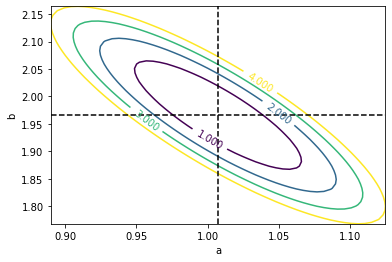

In [51]:
# or use this function for a quick look
m.draw_contour("a", "b");